In [20]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import kagglehub
from torch.utils.data import random_split,  DataLoader
from torchvision.models import vgg16, VGG16_Weights



In [21]:
# Download dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /home/oliveira/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [22]:
# TRansform to vgg standarts
transform = transforms.Compose([
        transforms.Resize(256),  
        transforms.CenterCrop(224),  
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  
])

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data = {
    'train': datasets.ImageFolder(root=os.path.join(path, 'chest_xray/train'), transform=transform_train),
    'val': datasets.ImageFolder(root=os.path.join(path, 'chest_xray/val'), transform=transform),
    'test': datasets.ImageFolder(root=os.path.join(path, 'chest_xray/test'), transform=transform)
}

#Use part of train to validation
train_len = int(0.9 * len(data['train']))
val_len = len(data['train']) - train_len
train_ds, val_ds = random_split(data['train'], [train_len, val_len])

batch_size=8
print(batch_size)
# Create dataloaders
dataloaders={
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

print(len(dataloaders['train'].dataset))
print(len(dataloaders['test'].dataset))
print(len(dataloaders['val'].dataset))

8
4694
624
522


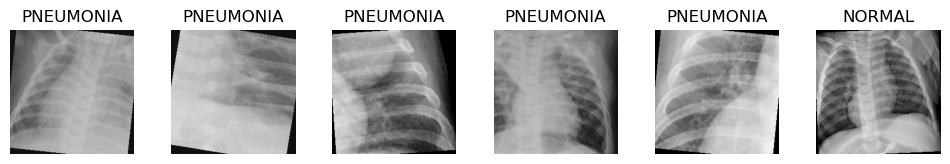

In [23]:
# Visualizing sample images
classes = data['train'].classes

class_names = data['train'].classes

fig, axes = plt.subplots(1, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
        inputs, classes = next(iter(dataloaders['train']))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i].imshow(inp)
        axes[i].set_title(class_names[class_label.item()])
        axes[i].axis('off')

plt.show()


In [24]:
def train(model, criterion, optimizer, scheduler, device, epochs=25):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = []
    acc_history = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset grads
            optimizer.zero_grad()

            #Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                #Backward
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        scheduler.step()
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        loss_history.append(epoch_loss)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)


        val_loss, val_acc = evaluate(model, criterion, device)
        acc_history.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"Época {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Acc: {val_acc:.4f}")
        

    model.load_state_dict(best_model_wts)
    torch.save(model, './best_model.pt')
    return model, loss_history, acc_history

In [25]:
def evaluate(model, criterion, device):
    model.to(device)
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():  # NO Grads
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    val_loss = running_loss / len(dataloaders['val'].dataset)
    val_acc = running_corrects.double() / len(dataloaders['val'].dataset)

    return val_loss, val_acc
    

In [26]:
def create_model():
    # vgg = models.vgg19(pretrained=True)
    # print(vgg16)
    
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)
    
    # Freeze Parameters
    for param in model.features.parameters():  
        param.requires_grad = False

    # Change last layer to adjust the number of out classes
    num_classes = 2
    model.classifier[6] = nn.Linear(4096, num_classes)

    return model

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create VGG16 Pre trained model
model = create_model()
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# DEfine scheduler decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [28]:
print("Starting training")
# TRAIN
model, train_loss_history, val_acc_history = train(model, criterion, optimizer, scheduler, device, epochs=50)

Starting training
Época 1/50, Loss: 0.3975, Accuracy: 0.8281, Validation Acc: 0.8487
Época 2/50, Loss: 0.3174, Accuracy: 0.8609, Validation Acc: 0.8314
Época 3/50, Loss: 0.3081, Accuracy: 0.8694, Validation Acc: 0.8678
Época 4/50, Loss: 0.2831, Accuracy: 0.8818, Validation Acc: 0.8851
Época 5/50, Loss: 0.2738, Accuracy: 0.8882, Validation Acc: 0.8659
Época 6/50, Loss: 0.2704, Accuracy: 0.8884, Validation Acc: 0.8429
Época 7/50, Loss: 0.2635, Accuracy: 0.8958, Validation Acc: 0.9042
Época 8/50, Loss: 0.2645, Accuracy: 0.8905, Validation Acc: 0.8851
Época 9/50, Loss: 0.2420, Accuracy: 0.8990, Validation Acc: 0.8755
Época 10/50, Loss: 0.2503, Accuracy: 0.8971, Validation Acc: 0.8602
Época 11/50, Loss: 0.2336, Accuracy: 0.9001, Validation Acc: 0.8755
Época 12/50, Loss: 0.2257, Accuracy: 0.9090, Validation Acc: 0.8889
Época 13/50, Loss: 0.2285, Accuracy: 0.9022, Validation Acc: 0.8851
Época 14/50, Loss: 0.2210, Accuracy: 0.9067, Validation Acc: 0.8908
Época 15/50, Loss: 0.2179, Accuracy: 0.

In [30]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.extend(labels.tolist())
            
            #Store model input images
            input_images.append(inputs)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.extend(preds.tolist())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [35]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

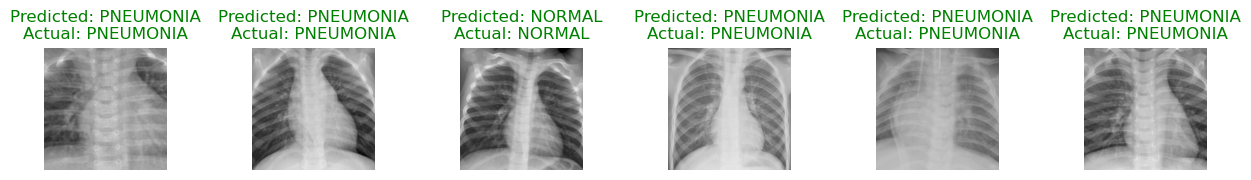

Total Correct: 569.0 
Total Test Images: 624.0
Test Accuracy:  0.9118589743589743


In [36]:
fig, axes = plt.subplots(1,6, figsize=(15, 15))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(6):
    # Get the image and labels
    inp = input_images[x].squeeze()
  
    true_label = true_labels[x]
    pred_label = pred_labels[x]

    # Normalize the image for display
    inp = inp[0]
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Display the image
    axes[i].imshow(inp)

    # Set the title with the predicted and actual labels
    title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(title, color=color)

    # Hide the axes
    axes[i].axis('off')

    # Move to the next image
    x += 1

plt.show()

print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

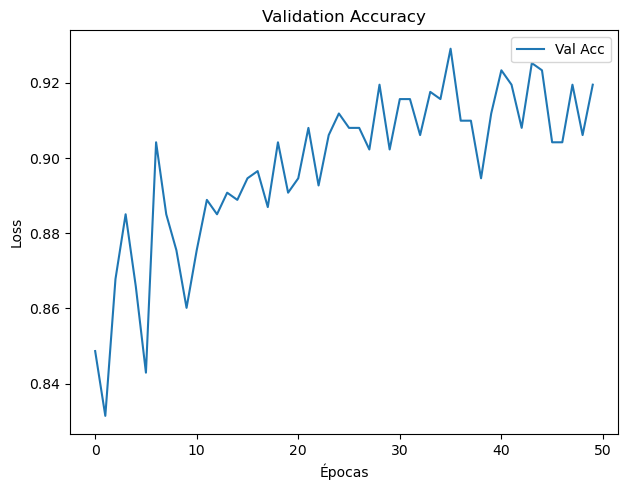

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.plot(acc, label='Test Acc')
plt.plot([v.cpu().item() if torch.is_tensor(v) else v for v in val_acc_history], label='Val Acc')

plt.title('Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()